In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate, add_weights, average_weights
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg, FedAvg_TopK
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

In [13]:
class my_argument:    
    epochs = 50    #"rounds of training"
    num_users = 100  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=5 #"the number of local epochs: E"
    local_bs=500 #"local batch size: B"
    bs=128 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 0 # 5e-4
    split='user' # "train-test split type, user or sample"

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")
    
    opt = 'ADAM'

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=0
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

In [14]:
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

print(f"imag_size={img_size}")

imag_size=torch.Size([1, 28, 28])


/usr/lib/python3/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [15]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

True
cuda


# 1. FedAvg without Sparsification

In [7]:
# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist2(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

for iter in range(args.epochs): #args.epochs
    w_locals, loss_locals = [], []
    m = 13
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    
    loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(acc_test)
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.366 Test accuracy 9.800

Test set: Average loss: 1.9826 
Accuracy: 6005/10000 (60.05%)

Round   1, Average loss 2.154 Test accuracy 60.050

Test set: Average loss: 0.6171 
Accuracy: 8776/10000 (87.76%)

Round   2, Average loss 1.606 Test accuracy 87.760

Test set: Average loss: 0.2882 
Accuracy: 9278/10000 (92.78%)

Round   3, Average loss 0.773 Test accuracy 92.780

Test set: Average loss: 0.2209 
Accuracy: 9465/10000 (94.65%)

Round   4, Average loss 0.662 Test accuracy 94.650

Test set: Average loss: 0.1939 
Accuracy: 9497/10000 (94.97%)

Round   5, Average loss 0.574 Test accuracy 94.970

Test set: Average loss: 0.1616 
Accuracy: 9571/10000 (95.71%)

Round

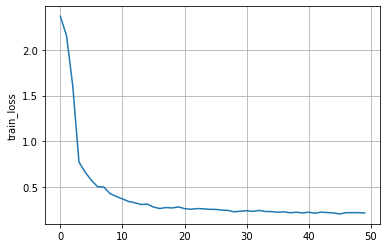

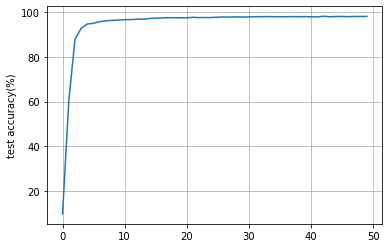

In [8]:
# plot loss curve
#print(loss_locals)
#print(loss_train)
# plt.figure()
plt.plot(range(len(loss_train)), loss_train)
plt.ylabel('train_loss')
plt.grid()
plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

loss_train_Fedavg = loss_train
acc_test_Fedavg = acc_test_arr

plt.plot(range(len(acc_test_Fedavg)), acc_test_Fedavg)
plt.ylabel('test accuracy(%)')
plt.grid()
plt.show()
#print(loss_train_Fedavg)

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.316 Test accuracy 9.800

Test set: Average loss: 1.7203 
Accuracy: 5257/10000 (52.57%)

Round   1, Average loss 2.022 Test accuracy 52.570

Test set: Average loss: 0.5145 
Accuracy: 8863/10000 (88.63%)

Round   2, Average loss 1.345 Test accuracy 88.630

Test set: Average loss: 0.2788 
Accuracy: 9303/10000 (93.03%)

Round   3, Average loss 0.743 Test accuracy 93.030

Test set: Average loss: 0.2152 
Accuracy: 9445/10000 (94.45%)

Round   4, Average loss 0.585 Test accuracy 94.450

Test set: Average loss: 0.1765 
Accuracy: 9540/10000 (95.40%)

Round   5, Average loss 0.533 Test accuracy 95.400

Test set: Average loss: 0.1452 
Accuracy: 9592/10000 (95.92%)

Round

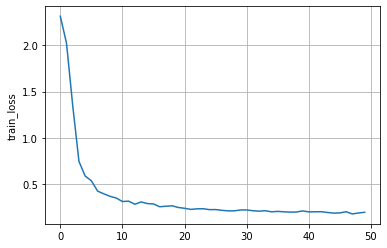

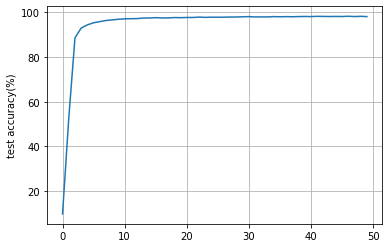

In [9]:
# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist2(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

for iter in range(args.epochs): #args.epochs
    w_locals, loss_locals = [], []
    m = 13
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device), is_send_gradient=True)
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    
    # Gradient Based udpate
    grad_glob = FedAvg(w_locals)
    current_model = net_glob.state_dict()
    current_model = add_weights(current_model, grad_glob)
    net_glob.load_state_dict(current_model)    



    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    
    loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(acc_test)
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)
    
    
# plot loss curve
#print(loss_locals)
#print(loss_train)
# plt.figure()
plt.plot(range(len(loss_train)), loss_train)
plt.ylabel('train_loss')
plt.grid()
plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

loss_train_Fedavg = loss_train
acc_test_Fedavg = acc_test_arr

plt.plot(range(len(acc_test_Fedavg)), acc_test_Fedavg)
plt.ylabel('test accuracy(%)')
plt.grid()
plt.show()
#print(loss_train_Fedavg)

# 2. Sparsified FedAvg

In [19]:
def Train_Sparse_Fed(Top_K_rate=0.1, _l1_weight=0.0):
    # build model
    if args.model == 'cnn' and args.dataset == 'cifar':
        net_glob = CNNCifar(args=args).to(args.device)
    elif args.model == 'cnn' and args.dataset == 'mnist':
        net_glob = CNNMnist2(args=args).to(args.device)
    elif args.model == 'mlp':
        len_in = 1
        for x in img_size:
            len_in *= x
        net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
    else:
        exit('Error: unrecognized model')
    print(net_glob)
    net_glob.train()

    # copy weights
    w_glob = net_glob.state_dict()

    # training
    loss_train = []
    loss_test_arr = []
    acc_test_arr = [] 
    aggregate_sparse_ratio = []
    sparse_ratio_bf_topk = []
    cv_loss, cv_acc = [], []
    val_loss_pre, counter = 0, 0
    net_best = None
    best_loss = None
    val_acc_list, net_list = [], []





    for iter in range(args.epochs): #args.epochs
        w_locals, loss_locals = [], []
        
        net_glob.zero_grad()
        
        m = 10 # number of selected user per epoch
        
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)
        
        for idx in idxs_users:
    #         print(idx)
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
            w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device), is_send_gradient=True, l1_weight = _l1_weight)
            w_locals.append(copy.deepcopy(w))
            loss_locals.append(copy.deepcopy(loss))
        # update global weights
        global_grads, total_len, total_count_non_zero, avg_count_non_zero_per_w = FedAvg_TopK(w_locals, K_rate = Top_K_rate)
        
        print(f"total_count_non_zero={total_count_non_zero}/{total_len} ({total_count_non_zero/total_len*100.0}%)")
        aggregate_sparse_ratio.append(total_count_non_zero/total_len)
        print(f"sparse_ratio_bf_topk={avg_count_non_zero_per_w}/{total_len} ({avg_count_non_zero_per_w/total_len*100.0}%)")
        sparse_ratio_bf_topk.append(avg_count_non_zero_per_w/total_len)
        
        # print(w_locals)
        
        
        # print(global_grads)
        
        # global_grads = average_weights(w_locals, device_id=args.gpu)
        
        
        current_model = net_glob.state_dict()

        current_model = add_weights(current_model, global_grads)

        net_glob.load_state_dict(current_model)


        # print loss
        loss_avg = sum(loss_locals) / len(loss_locals)
        loss_train.append(loss_avg)
        #print(loss_train)
        
        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr.append(acc_test)
        loss_test_arr.append(loss_test)
        if iter % 1 ==0:
            print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            
    return sparse_ratio_bf_topk, aggregate_sparse_ratio, loss_train, acc_test_arr             
        
        

In [25]:
import pickle

K_sparse_rates = [0.1]
l1_weights = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0]


# K_sparse_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
# l1_weights = [0.0]


args.epochs = args.epochs


aggregate_sparse_ratio_all = np.zeros((len(K_sparse_rates), len(l1_weights), args.epochs))
sparse_ratio_bf_topk_all = np.zeros((len(K_sparse_rates), len(l1_weights), args.epochs))
loss_train_all = np.zeros((len(K_sparse_rates), len(l1_weights), args.epochs))
acc_test_arr_all  = np.zeros((len(K_sparse_rates), len(l1_weights), args.epochs))


for k, K_rate in enumerate(K_sparse_rates):
    for i, l1_weight in enumerate(l1_weights):
        print(f"K_rate={K_rate}, l1_weight={l1_weight}")
        # aggregate_sparse_ratio_all[k][i] = k*10 + i
        sparse_ratio_bf_topk_all[k,i,:], aggregate_sparse_ratio_all[k,i,:],  loss_train_all[k,i,:], acc_test_arr_all[k,i,:] = Train_Sparse_Fed(K_rate, l1_weight)
        print("\n\n\n")

# print(aggregate_sparse_ratio_all[k][i])

K_rate=0.1, l1_weight=0.1
CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)


TypeError: count_nonzero(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [21]:
pickle.dump(sparse_ratio_bf_topk_all,   open('./results/NonIID_l1Reg_sparse_ratio_bf_topk_all', 'wb'))
pickle.dump(aggregate_sparse_ratio_all, open('./results/NonIID_l1Reg_aggregate_sparse_ratio_all', 'wb'))
pickle.dump(loss_train_all,             open('./results/NonIID_l1Reg_loss_train_all', 'wb'))
pickle.dump(acc_test_arr_all,           open('./results/NonIID_l1Reg_acc_test_arr_all', 'wb'))

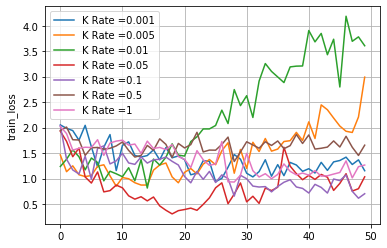

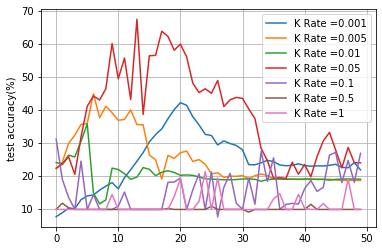

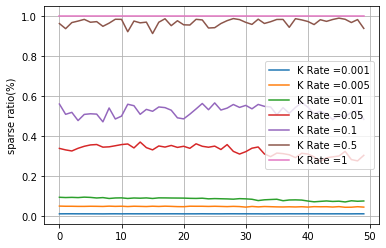

In [9]:
# plot loss curve
#print(loss_locals)
#print(loss_train)
# plt.figure()
for k in range(len(K_sparse_rates)):
    plt.plot(range(args.epochs), loss_train_all[k,0,:], label='K Rate ={}'.format(K_sparse_rates[k]))
    

plt.legend()
plt.ylabel('train_loss')
plt.grid()
plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))


for k in range(len(K_sparse_rates)):
    plt.plot(range(args.epochs), acc_test_arr_all[k,0,:], label='K Rate ={}'.format(K_sparse_rates[k]))

plt.legend()
plt.ylabel('test accuracy(%)')
plt.grid()
plt.show()

for k in range(len(K_sparse_rates)):
    plt.plot(range(args.epochs), aggregate_sparse_ratio_all[k,0,:], label='K Rate ={}'.format(K_sparse_rates[k]))

plt.legend()
plt.ylabel('sparse ratio(%)')
plt.grid()
plt.show()



#print(loss_train_Fedavg)

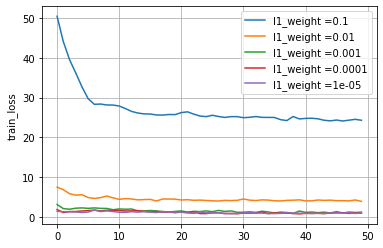

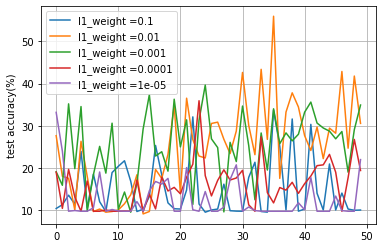

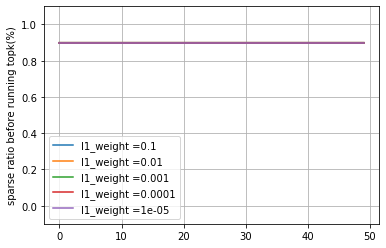

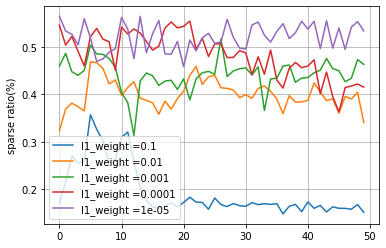

In [24]:
# plot loss curve
#print(loss_locals)
#print(loss_train)
# plt.figure()
for k in range(len(l1_weights)-1):
    plt.plot(range(args.epochs), loss_train_all[0,k,:], label='l1_weight ={}'.format(l1_weights[k]))
    

plt.legend()
plt.ylabel('train_loss')
plt.grid()
plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))


for k in range(len(l1_weights)-1):
    plt.plot(range(args.epochs), acc_test_arr_all[0,k,:], label='l1_weight ={}'.format(l1_weights[k]))

plt.legend()
plt.ylabel('test accuracy(%)')
plt.grid()
plt.show()


for k in range(len(l1_weights)-1):
    plt.plot(range(args.epochs), sparse_ratio_bf_topk_all[0,k,:], label='l1_weight ={}'.format(l1_weights[k]))

plt.legend()
plt.ylim([-0.1, 1.1])
plt.ylabel('sparse ratio before running topk(%)')
plt.grid()
plt.show()


for k in range(len(l1_weights)-1):
    plt.plot(range(args.epochs), aggregate_sparse_ratio_all[0,k,:], label='l1_weight ={}'.format(l1_weights[k]))

plt.legend()
plt.ylabel('sparse ratio(%)')
plt.grid()
plt.show()



#print(loss_train_Fedavg)

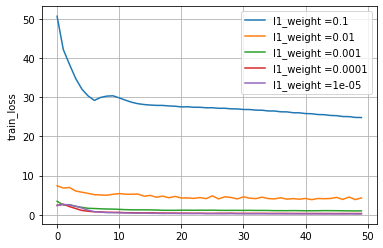

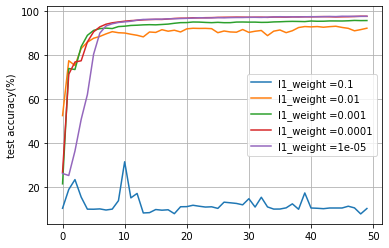

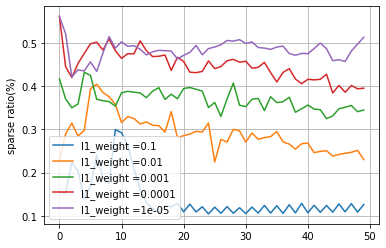

In [41]:
# plot loss curve
#print(loss_locals)
#print(loss_train)
# plt.figure()
for k in range(len(l1_weights)):
    plt.plot(range(args.epochs), loss_train_all[0,k,:], label='l1_weight ={}'.format(l1_weights[k]))
    

plt.legend()
plt.ylabel('train_loss')
plt.grid()
plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))


for k in range(len(l1_weights)):
    plt.plot(range(args.epochs), acc_test_arr_all[0,k,:], label='l1_weight ={}'.format(l1_weights[k]))

plt.legend()
plt.ylabel('test accuracy(%)')
plt.grid()
plt.show()

for k in range(len(l1_weights)):
    plt.plot(range(args.epochs), aggregate_sparse_ratio_all[0,k,:], label='l1_weight ={}'.format(l1_weights[k]))

plt.legend()
plt.ylabel('sparse ratio(%)')
plt.grid()
plt.show()



#print(loss_train_Fedavg)